---

---

---
The goal of this exercise was to create a plot to help visualize event activity reported by Google Analytics. This view provides valuable insight, and helps to answer a variety of questions:

- What does the current development cycle look like (with an emphasis on GA event tracking tags)?
- How frequently are tags updated?
- Which events should be considered active/inactive?
- Which events are related to one another?
- What data quality issues might exist due to current tag setup?

---

In [1]:
import sys
import os
import time
import datetime as dt
from collections import OrderedDict

import numpy as np
import pandas as pd

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.font_manager as font_manager
import matplotlib.dates
from matplotlib.dates import WEEKLY, MONTHLY, DateFormatter, rrulewrapper, RRuleLocator 

In [2]:
url_base = "https://docs.google.com/spreadsheets/d/"
sheet_id = "1OE3XZK-kxGCuwdhWx_a_4y2OaoeBIS2SP79mISssWd0"
url_params = "/pub?gid=0&single=true&output=csv"

sheet_url = url_base + sheet_id + url_params
print (sheet_url)

https://docs.google.com/spreadsheets/d/1OE3XZK-kxGCuwdhWx_a_4y2OaoeBIS2SP79mISssWd0/pub?gid=0&single=true&output=csv


requesting data...
data received.
(124, 3)


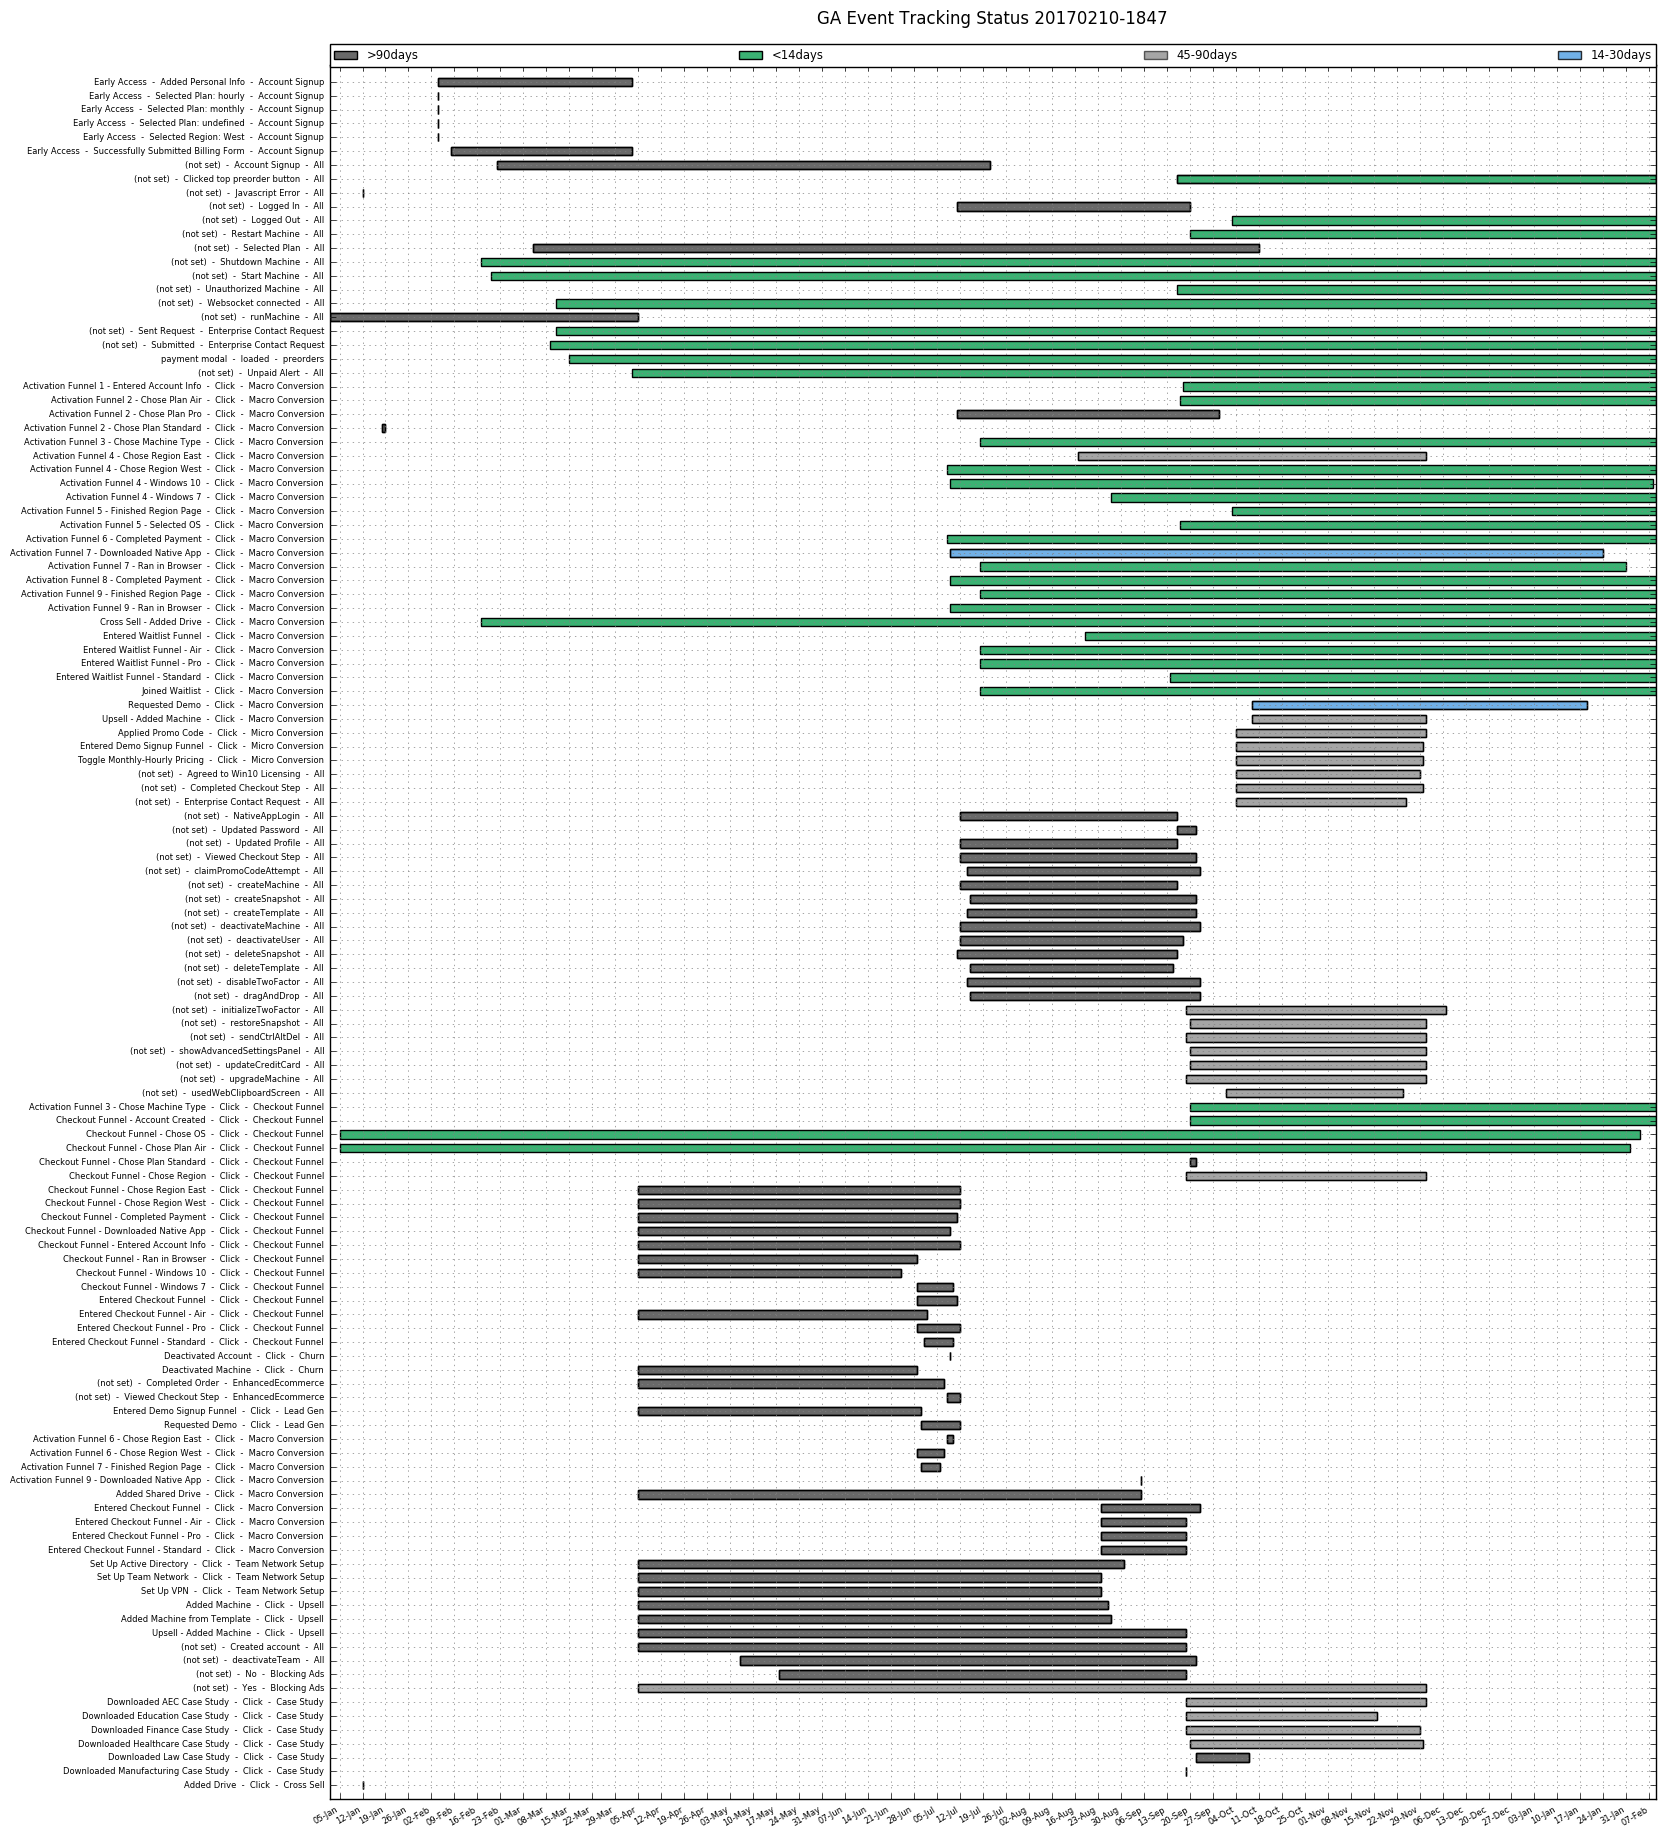

In [3]:
def get_date(datetxt):
    """prep date for matplotlib"""
    mdate = matplotlib.dates.date2num(datetxt)
    return mdate

def load_data(source):
    """Load csv data from Google Sheets (or other csv source)"""
    print('requesting data...')
    df = pd.read_csv(source,
                 parse_dates = ['Date'])
    print('data received.')
    return transform_df(df)


def transform_df(orig_data):
    """create new transformed df"""
    orig_data['lookup'] = orig_data['Event Category'] + ',' + orig_data['Event Action'] + ',' + orig_data['Event Label']
    dfx = pd.DataFrame(pd.Series(list(orig_data['lookup'].unique())).str.split(',').tolist(), 
                       columns=['Event Category','Event Action','Event Label'])
    print(dfx.shape)
    dfx['lookup'] = dfx['Event Category'] + ',' + dfx['Event Action'] + ',' + dfx['Event Label']
    dfx['start_date'] = list(orig_data.groupby('lookup')['Date'].min())
    dfx['end_date'] = list(orig_data.groupby('lookup')['Date'].max())
    dfx['gantt_blank'] = dfx['start_date'] - orig_data['Date'].min()
    dfx['gantt_active'] = dfx['end_date'] - dfx['start_date']
    return create_gantt_chart(dfx)


def create_gantt_chart(data):
    """Create plot, save file"""

    ylabels = []
    xdates = []
    
    for i, row in data.iterrows():
        ylabel = row['Event Category']
        event_action = row['Event Action']
        event_label = row['Event Label']
        startdate = row['start_date']
        enddate = row['end_date']
        gantt_blank = row['gantt_blank']
        gantt_active = row['gantt_active']
        
        # format ylabel to help as a quick and dirty visual aid
        ylabel = event_label + "  -  " + event_action + "  -  " + ylabel
        
        ylabels.append(ylabel.replace('\n',''))
        xdates.append([get_date(startdate),get_date(enddate)])

    ycount=len(ylabels)
    pos = np.arange(0.5,ycount*0.5+0.5,0.5)
    event_dates = {}
    for i,event in enumerate(ylabels):
        event_dates[event] = xdates[i]
    
    # plot output w,h
    fig = plt.figure(figsize=(17,22))
    ax = fig.add_subplot(111)
    
    daysago90 = (data['end_date'].max() - dt.timedelta(days=90)).toordinal()
    daysago45 = (data['end_date'].max() - dt.timedelta(days=45)).toordinal()
    daysago30 = (data['end_date'].max() - dt.timedelta(days=30)).toordinal()
    daysago14 = (data['end_date'].max() - dt.timedelta(days=14)).toordinal()
    
    clrs = {
        'green':'#3BB273',
        'blue':'#4D9DE0',
        'purple':'#7768AE',
        'red':'#E15554',
        'yellow':'#E1BC29'
    }
    
    labelflags = {'daysago90':0,
                  'daysago45':0,
                  'daysago30':0,
                  'daysago14':0,
                  'current':0}
    
    for i in range(len(ylabels)):
        start_date,end_date = event_dates[ylabels[i]]
        
        # if no activity in past month, consider event dormant 
        if end_date<daysago90:
            if labelflags['daysago90'] is 0:
                ax.barh((i*0.5)+0.5, end_date - start_date, left=start_date, height=0.3, align='center', color='dimgrey', alpha = 1., zorder=0, label=">90days")
                ax.barh((i*0.5)+0.5, end_date - start_date, left=start_date, height=0.3, align='center', color='none', edgecolor='k', zorder=1)
                labelflags['daysago90'] = 1
            else:
                ax.barh((i*0.5)+0.5, end_date - start_date, left=start_date, height=0.3, align='center', color='dimgrey', alpha = 1., zorder=0)
                ax.barh((i*0.5)+0.5, end_date - start_date, left=start_date, height=0.3, align='center', color='none', edgecolor='k', zorder=1)
        elif end_date>daysago90 and end_date<daysago45:
            if labelflags['daysago45'] is 0:
                ax.barh((i*0.5)+0.5, end_date - start_date, left=start_date, height=0.3, align='center', color='dimgrey', alpha = 0.6, zorder=0, label="45-90days")
                ax.barh((i*0.5)+0.5, end_date - start_date, left=start_date, height=0.3, align='center', color='none', edgecolor='k', zorder=1)
                labelflags['daysago45'] = 1
            else:
                ax.barh((i*0.5)+0.5, end_date - start_date, left=start_date, height=0.3, align='center', color='dimgrey', alpha = 0.6, zorder=0)
                ax.barh((i*0.5)+0.5, end_date - start_date, left=start_date, height=0.3, align='center', color='none', edgecolor='k', zorder=1)
        elif end_date>daysago45 and end_date<daysago30:      
            if labelflags['daysago30'] is 0:
                ax.barh((i*0.5)+0.5, end_date - start_date, left=start_date, height=0.3, align='center', color=clrs['purple'], alpha = 0.8, zorder=0,label="30-45days")
                ax.barh((i*0.5)+0.5, end_date - start_date, left=start_date, height=0.3, align='center', color='none', edgecolor='k', zorder=1)
                labelflags['daysago30'] = 1
            else:
                ax.barh((i*0.5)+0.5, end_date - start_date, left=start_date, height=0.3, align='center', color=clrs['purple'], alpha = 0.8, zorder=0)
                ax.barh((i*0.5)+0.5, end_date - start_date, left=start_date, height=0.3, align='center', color='none', edgecolor='k', zorder=1)
        elif end_date>daysago30 and end_date<daysago14:
            if labelflags['daysago14'] is 0:
                ax.barh((i*0.5)+0.5, end_date - start_date, left=start_date, height=0.3, align='center', color=clrs['blue'], alpha = 0.8, zorder=0, label="14-30days")
                ax.barh((i*0.5)+0.5, end_date - start_date, left=start_date, height=0.3, align='center', color='none', edgecolor='k', zorder=1)
                labelflags['daysago14'] = 1
            else:
                ax.barh((i*0.5)+0.5, end_date - start_date, left=start_date, height=0.3, align='center', color=clrs['blue'], alpha = 0.8, zorder=0)
                ax.barh((i*0.5)+0.5, end_date - start_date, left=start_date, height=0.3, align='center', color='none', edgecolor='k', zorder=1)
        else:
            if labelflags['current'] is 0:
                ax.barh((i*0.5)+0.5, end_date - start_date, left=start_date, height=0.3, align='center', color=clrs['green'], alpha = 1., zorder=0, label="<14days")
                ax.barh((i*0.5)+0.5, end_date - start_date, left=start_date, height=0.3, align='center', color='none', edgecolor='k', zorder=1)
                labelflags['current'] = 1
            else:
                ax.barh((i*0.5)+0.5, end_date - start_date, left=start_date, height=0.3, align='center', color=clrs['green'], alpha = 1., zorder=0, lw=0.5)
                ax.barh((i*0.5)+0.5, end_date - start_date, left=start_date, height=0.3, align='center', color='none', edgecolor='k', zorder=1)

    
    locsy, labelsy = plt.yticks(pos,ylabels)
    plt.setp(labelsy, fontsize = 6)
    ax.set_ylim(ymin = -0.1, ymax = ycount*0.5+0.5)
    ax.set_xlim([data['start_date'].min(),data['end_date'].max()])
    
    
    ax.grid(color = 'grey', linestyle = ':')
    ax.xaxis_date()
    rule = rrulewrapper(WEEKLY, interval=1)
    loc = RRuleLocator(rule)
    formatter = DateFormatter("%d-%b")
  
    ax.xaxis.set_major_locator(loc)
    ax.xaxis.set_major_formatter(formatter)
    labelsx = ax.get_xticklabels()
    plt.setp(labelsx, rotation=30, fontsize=6)
 
    font = font_manager.FontProperties(size='small')
    ax.legend(bbox_to_anchor=(0., 0.91, 1., .102), loc='upper center', ncol=5, mode="expand", borderaxespad=0.,prop=font)
 
    ax.invert_yaxis()
    
    plt.subplots_adjust(top=0.2)
    plt.tight_layout(pad=1.75)
    
    
    # rotate date ticklabels
    fig.autofmt_xdate()
    plt.title('GA Event Tracking Status ' + str(dt.date.strftime(dt.datetime.now(),"%Y%m%d-%H%M")), y=1.02, fontsize=12)
    plt.savefig('tag_events_'+str(dt.date.strftime(dt.datetime.now(),"%Y%m%d-%H%M"))+'.png')
    plt.show()


if __name__ == '__main__':
    load_data(sheet_url)